# Reproduction of the PORPOISE paper 


The purpose of this notebook is to partially reconstruct the results of the paper [Pan-Cancer Integrative Histology-Genomic Analysis via Multimodal Deep Learning](https://www.cell.com/cancer-cell/fulltext/S1535-6108(22)00317-8) which introduced the **PORPOISE** platform, therefore this notebook will refer to the paper as the PORPOISE paper for readability.

More specifically, this notebook reconstructs the multimodal model that classifies survival prediction from the combination of histological slides and genomic data. 
The model consists of an attention MIL aggregation on bags of previously extracted feature vectors from Whole Slide Imags (WSI) and a SNN encoding the molecular profile data (mutation status, copy-number variation, RNA sequencing).
 
Both modalities are then fused so that a classification head can be applied to predict survival. The aggregation of the WSI feature vectors, the SNN for genomics, the fusion and the classification head are jointly trained by back-propagation of the Cox loss. 

The blocks are implemented as described in the paper and commented so as to be understandable, but also compatible, so that they can later be combined into a single pipeline for training and evaluation purposes.



![width=6](imgs/porpoisemodel.png)


![](image.png)

In [2]:
import torch
from torch import nn 

## Attention MIL
The Attention MIL model from the [Paper](https://arxiv.org/pdf/1802.04712) 'Attention-based Deep Multiple Instance Learning' by   M. Ilse et al 
is a convenient method to evaluate large gigapixel images based on the multiple instance learning principle. 
The gigapixel images are cropped into multiple non-overlapping tiles and collected in a so called bag of tiles, which are then independently encoded with the same pretrained feature encoder, giving each tile a weak label. Finally the bag of encoded feature vectors is aggregated with an aggregation model, which in this case is an attention based pooling. 

1. Using a preexisting preprocessing code(*), the notebooks assumes that the histological information is provided as a folder with tensors, each containing the bag of feature vectors from one patient. 
2.  Similiar to self-attention, we linearly project the input tensor with the weight tensors  U and V and then join them  by elementwhise multiplication $\odot$ (instead of matrix multiplication as it is done in self-attention). A further projection with a row whise softmax leads to scalar attention scores for each feature vector which are used for a weighted sum as aggregation.
 \begin{equation}
\mathbf{z} = \sum_{k=1}^K a_k \mathbf{h}_k
\end{equation}

where the weight $a_k$ is calculated with
\begin{equation}
a_k =softmax \left( \mathbf{w}^T ( tanh( \mathbf{V h}_k^T) \odot sigm( \mathbf{U h}_k^T ) )  \right) 
\end{equation}


with dimensions $\mathbf{w} \in  \mathbb{R}^{Lx1}$ and  $\mathbf{V,U} \in  \mathbb{R}^{LxM}$


(*)Due to time reasons and not reinventing the wheel once again, the [end2end preprocessing pipeline](https://github.com/KatherLab/end2end-WSI-preprocessing) by Kather et al can be used, which takes the WSI, crops the WSI into tiles, gets rid of worthless tiles(those who are too blurry or mostly containing background), applies a Macenko normalization to each tile and finally uses a pre trained feature encoder for the vector embedding. 

In [3]:
class AttMil(nn.Module):
    """ 
    Implementation of  
    'Attention-based Deep Multiple Instance Learning' 
    by   M. Ilse et al (https://arxiv.org/pdf/1802.04712)
    Gated Attention Mechanism 
    
    Variables: 
    d : dimension of fwature vectors
    """
    def __init__(self,d : int):
        super(AttMil,self).__init__()
        self.lin1 = nn.Linear(d,d//2,bias = True)
        torch.nn.init.xavier_normal_(self.lin1.weight)
        self.lin2 = nn.Linear(d//2,d//4,bias=False)
        torch.nn.init.xavier_normal_(self.lin2.weight)
        self.lin3 = nn.Linear(d//2,d//4,bias=False)
        torch.nn.init.xavier_uniform_(self.lin3.weight)
        self.lin4 = nn.Linear(d//4,1,bias=False)
        torch.nn.init.xavier_normal_(self.lin4.weight)
        self.tanh = nn.Tanh()
        self.sigm = nn.Sigmoid()
        self.sm = nn.Softmax(dim = 1)

    def forward(self,x):
        x = self.lin1(x)  
        U = self.sigm(self.lin2(x))
        V = self.tanh(self.lin3(x))
        UV= self.lin4(V*U).squeeze(dim=-1) # (B,m,d/4) -> (B,m,1) -> (B,m)
        a = self.sm(UV).unsqueeze(-2)  # (B,m) -> (B,1,m)
        out = torch.bmm(a,x).squeeze(1) # (B,1,m)x(B,m,d/2) ->(B,1,d/2) -> (B,d/2)   or    (m1,m2,...m)x(x1|x2|x3|...)^T  or Σ a_i * x_i
        return out


Sanity check: providing a random tensor of dimneison (B,m,d1) representing a **B**atch of bags with the same length **m** of vectors with the same **d**imension.

The AttMIL model encodes each bag into a vector of size 512 using trainable weights.


In [4]:
## Attention MIL 
B= 16  # batchsize MUST BE B%4=0 
m = 15  # number of vectors encoded from tiles 
d1 = 1024   # initial dimension of vectors
H = torch.rand(B,m,d1) # (Pseudo) Input Tensor 

model1 = AttMil(d=d1)
model1(H).size()

torch.Size([16, 512])

## SNN

The following block shows the implementation as described in the [paper]( https://pubmed.ncbi.nlm.nih.gov/35944502/) 'Pan-cancer integrative histology-genomic analysis via multimodal deep learning' by R.Chen et al using the self normalizing activation function within a fully connected neural network.
   

In [34]:
class SNN(nn.Module):
    """ Implementation of SNN as described in 'Pan-cancer integrative histology-genomic analysis via multimodal deep learning' by R.Chen et al 
    https://pubmed.ncbi.nlm.nih.gov/35944502/ 
    
    Variables:
    d : dimension of molecular vector
    d_out : dimnesion of embedded output vector 
    """
    def __init__(self,d : int,d_out : int = 32):
        super(SNN,self).__init__()

        self.lin1 = nn.Linear(d,256)
        self.lin2 = nn.Linear(256,256)
        
        self.selu1 = nn.SELU()
        self.selu2 = nn.SELU()
        self.alphadropout1 = nn.AlphaDropout(p=0.5)
        self.alphadropout2 = nn.AlphaDropout(p=0.5)
        self.fc = nn.Linear(256,d_out)
        self.selu3 = nn.SELU()
        #weight init
        torch.nn.init.normal_(self.lin1.weight, mean=0, std=1/d**0.5)
        torch.nn.init.normal_(self.lin2.weight, mean=0, std=1/256**0.5)
        torch.nn.init.normal_(self.fc.weight, mean=0, std=1/256**0.5)
        
    def forward(self,x):

        x = self.alphadropout1(self.selu1(self.lin1(x)))
        x = self.alphadropout2(self.selu2(self.lin2(x)))
        x = self.fc(x)
        return self.selu3(x)

    

In [36]:
#Sanitycheck: 
d2 = 1000
d_out_gen = 32
model2 = SNN(d=d2,d_out=d_out_gen)
x = torch.rand(B,d2) # Pseudo Input Tensor containing one vector per patient 
model2(x).size() # the encoded vector is of size 32 as proposed by the paper 

torch.Size([16, 32])

## Multimodal Fusion
To join the embeddings of both modalities, the first proposal of the PORPOISE paper is **Tensor Fusion**.
1. Input vectors of both modalities are extended by one dimension where a 1 is added as a value, allowing the model to gain information from a single modality as well. 
2. The Kronecker product is applied, giving a tensor of size (d1+1)x(d2+1) for each patient, where d1= histological embedding dimension, and d2= genomic embedding dimension.
3. Since a batch-wise Kronecker product is not implemented in Torch, for two modalities this can simply be solved by the outer product of the two vectors which can be realised by a matrix multiplication of a column and a row vector. 

$kronecker(u,v) = u*v^T$

In [28]:
def Fusion(v1,v2):
    """ 
    Implementation of Ungated Fusion for two modalities as described in 'Pan-cancer integrative histology-genomic analysis via multimodal deep learning' by R.Chen et al 
    https://pubmed.ncbi.nlm.nih.gov/35944502/ 
    No trainable variables, outputs the kronecker product of two vectors. Ones are appended before the kronecker product
    """
    assert v1.size(0) == v2.size(0)
    B = v1.size(0)
    p = torch.ones((B,1)) 
    v1 = torch.cat((v1,p),dim=-1) # add one values 
    v2 = torch.cat((v2,p),dim=-1) # add one values 
    
    return torch.bmm(v1.unsqueeze(-1),v2.unsqueeze(-2))  # 'In the case of column vectors, the Kronecker product can be viewed as a form of vectorization (or flattening) of the outer product.' -Wikipedia

In [29]:
#Sanity check
x1 = torch.rand((B,m,d1))  # bag of feature vectors from tiles
x2 = torch.rand((B,d2))  # genetic information per patient 

# trained feature embedding for each modality 
hist = model1(x1)
gen = model2(x2)

print(f"     Hist size: {hist.size()}")
print(f"      Gen size: {gen.size()}")
print(f"Outtensor size: {Fusion(hist,gen).size()}") 

     Hist size: torch.Size([16, 512])
      Gen size: torch.Size([16, 32])
Outtensor size: torch.Size([16, 513, 33])


## Gated Fusion 
Second fusion option: For a more balanced fusion of modalities the authors of the [paper]( https://arxiv.org/abs/1912.08937)  proposed 

a gated fusion which was also implemented in PORPOISE. It could be interpreted as  cross-attention based with respect to all modalities. 


In [25]:
class Gated_Fusion(nn.Module):
    """ 
    'Pathomic Fusion' by R.Chen et al 
    https://arxiv.org/abs/1912.08937
    Gated Fusion for two modalities 
    
    Variables:
    n_mods : Number of modalities
    dims : list of dimensions for each modality
    modalities : list of trainable feature embeddings from each modality
    """
    def __init__(self,n_mods: int ,dims: list[int] ):
        super(Gated_Fusion,self).__init__()
        self.n_mods = n_mods
        self.dims = dims
        #H emb
        lin1h = nn.Linear(dims[0],dims[0])
        lin2h = nn.Linear(dims[1],dims[1])
        
        self.h_emb1 = nn.Sequential(lin1h,nn.ReLU())
        self.h_emb2 = nn.Sequential(lin2h,nn.ReLU())
        #Z emb
        lin_1z = nn.Linear(sum(dims),dims[0])
        lin_2z = nn.Linear(sum(dims),dims[1])
        
        self.z_emb1 = nn.Sequential(lin_1z,nn.Sigmoid())
        self.z_emb2 = nn.Sequential(lin_2z,nn.Sigmoid())
        #weight init
        torch.nn.init.kaiming_normal_(lin1h.weight)
        torch.nn.init.kaiming_normal_(lin1h.weight)
        torch.nn.init.xavier_normal_(lin_1z.weight)
        torch.nn.init.xavier_normal_(lin_2z.weight)
    def forward(self,mod1,mod2 ):
        #first modality 
        h_1 =  self.h_emb1(mod1) # Projection of first modalitiy 
        z_1 = self.z_emb1(torch.cat((mod1,mod2),dim=1))  # concatenation and projection of all modalities concatenated 
        h_1_gated = h_1*z_1  # Attention
        
        # Same for second modality 
        h_2 =  self.h_emb2(mod2) 
        z_2 = self.z_emb2(torch.cat((mod1,mod2),dim=1))
        h_2_gated = h_2*z_2

        return Fusion(h_1_gated,h_2_gated)


In [27]:
## Sanity check:
modalities = [hist,gen]
n = len(modalities)  # number of modalities 
dims = [mods.size(1) for mods in modalities]
model3 = Gated_Fusion(n,dims = [mods.size(1) for mods in modalities])



print(f"     hist size: {hist.size()}")
print(f"      gen size: {gen.size()}")
print(f"outtensor size: {model3(modalities).size()}") 

     hist size: torch.Size([16, 512])
      gen size: torch.Size([16, 32])
outtensor size: torch.Size([16, 513, 33])


## Classification
The model aims to predict the survival outcome, which was previously been categorized based on the patient's survival days.\
We therefore place a classification head on top of the fusion to predict one of the four classes.
1. We implement the  classification head as described in the PORPOISE paper 
2. the output vector  is of depth 4, each representing one bin of a discretized survival time range  


In [40]:
class Classifier_Head(nn.Module):
    def __init__(self,outsize,d_hidden=256,t_bins=4):
        super(Classifier_Head,self).__init__()

        self.linear1 = nn.Linear(outsize,d_hidden)
        self.activ1 = nn.ReLU()
        self.linear2  = nn.Linear(d_hidden,d_hidden)
        self.activ2 = nn.ReLU()
        self.fc = nn.Linear(d_hidden,t_bins) # TODO test add layer
        torch.nn.init.kaiming_normal_(self.linear1.weight)
        torch.nn.init.kaiming_normal_(self.linear2.weight)
        
    def forward(self,x):
        x = torch.flatten(x,start_dim=1)
        x = self.activ1(self.linear1(x))
        x = self.activ2(self.linear2(x))
        return self.fc(x)

## PORPOISE

now one can combine the blocks into the whole model


## Survival 
The trials are limited to time periods. Within these time windows, data were collected from tumour patients. The days-to-event is determined, counting from the day the tumour was diagnosed(?) to the last day the patient was seen alive. If the patient did not die before the end of the trial, the vital status is recorded as 'alive', otherwise as 'dead'.
Patients can therefor be divided by their vital status:
1. **Uncensored patients**: If the patient is known to be dead, the survival time is exactly known. 
2. **Censored patients**: If the patient was still alive, the exact survival is not known. However, it is known that the event has not occured yet 

Further the Authors of the paper binned the continious survival time to discrete bins with the mapping  
$$
M(t): [0,\infty)\rightarrow
\begin{cases}
0&\text{if $t \in [0,t_1)$}\\
1&\text{if $t \in [t_1,t_2)$}\\
2&\text{if $t \in [t_2,t_3)$}\\
3&\text{if $t \in [t_3,\infty)$}\\
\end{cases}
$$
Where the boundaries $t_i$ where chosen such that the uncensored patients were equaliy distributed in each bin. 
So in the case of 4 bins, each bin represents a quartile of the uncensored patients.

### Let's first analyse a random Clini table:

In [3]:
#!pip install openpyxl
#!pip install seaborn
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
df = pd.read_excel("example_clini.xlsx")
print(df["Vital status"].value_counts())
df[["Days to last known alive","Vital status"]].head(11)

Vital status
Alive    642
Dead     276
Name: count, dtype: int64


,Days to last known alive,Vital status
0,784.0,Dead
1,951.0,Dead
2,435.0,Dead
3,232.0,Dead
4,180.0,Dead
5,424.0,Dead
6,272.0,Dead
7,494.0,Dead
8,987.0,Dead
9,475.0,Alive


Text(0, 0.5, 'Patients')

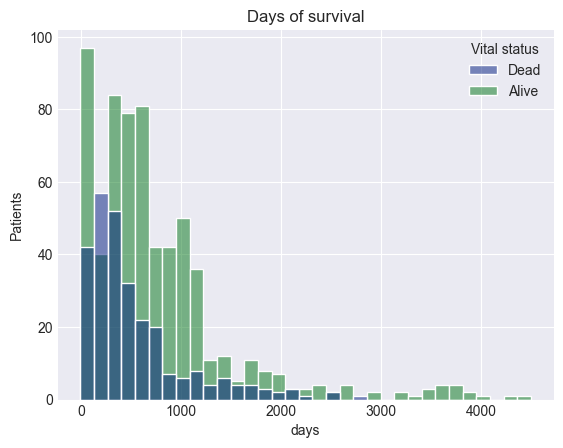

In [94]:
plt.clf()
plt.style.use('seaborn-v0_8-darkgrid')
#plt.hist(df["Days to last known alive"])
sns.histplot(data=df,x="Days to last known alive",hue="Vital status",)
plt.title("Histogram of Days of survival")
plt.xlabel("days")
plt.ylabel("Patients")

### Survival Lossfunction 
 <span style="color:red">  # TODO  </span> explain hazard function, Survival function with equation 

the Lossfunction used in PORPOISE is based on the proposed loss of the [paper](https://pubmed.ncbi.nlm.nih.gov/32149626/) by Zadeh et al which seems to be an improvement to the basic cross entropy loss usually used for survival networks 
 <span style="color:red">  # TODO  </span> write down loss equation 




In [43]:
def survival_loss(out,c,t,alpha):
    """
    'Bias in Cross-Entropy-Based Training of Deep Survival Networks' by S.Zadeh and M.Schmid 
    https://pubmed.ncbi.nlm.nih.gov/32149626/
    Improved negative loglikeliehood loss  
    
    Variables:
    out : torch.FloatTensor  output logits of the model 
    c : torch.BoolTensor wether the patient is censored(c=1) or ucensored(c=0)
    t : torch.IntTensor label/ground truth of the index where the time-to-event is nested
    alpha : float value within [0,1] weighting the Loss of the censored patients 
    """
    
    h = nn.Sigmoid()(out) #   Hazard function 
    S = torch.cumprod(1-h,dim = -1)  # Survival function

    t = t.unsqueeze(-1)
    S_bar = torch.cat((torch.ones_like(t),S),dim=-1) # padded survival function to get acess to the previous time window 

    # gathering the probabilty within the bin with the ground truth index for hazard,survival and padded survival 
    S = S.gather(dim=-1,index=t)
    h = h.gather(dim=-1,index=t)
    S_bar = S_bar.gather(dim=-1,index = t)
    
    
    
    #applying log function  
    logS = torch.log(S)
    logS_bar = torch.log(S_bar)
    logh = torch.log(h)

    #masking by censored or uncensored 
    # L_z(h,S) -> h,S_bar only uncensored,
    # while  L_censored(S) only censored 
    logh = logh*(1-c)
    logS_bar = logS_bar*(1-c)
    logS = logS*c


    L_z = -(logh+logS_bar) # -torch.sum(logS_bar) # only uncensored needed! for h and S_bar 
    L_censored = -(logS) # only censored S 
    
    
    return L_z + (1-alpha)*L_censored

### Comparing the result with the given loss function 

In [98]:
from PORPOISE.utils.loss_func import NLLSurvLoss
import torch 
from torch import nn 

B = 10 
n_bins = 4 
alpha = 0
seed = torch.manual_seed(5)

#generated input 
out = torch.rand((B,4), generator = seed)  ## Logits output from the model f(x) = out 
t = torch.randint(low=0, high=n_bins, size=(B,1), generator = seed)  ## label as index value for the ground truth time window where the event ocurred
c = torch.randint(low=0, high=2, size=(B,1), generator = seed)  ## Groundtruth boolean information wether the the patient is censored  c = 1 or uncensored  
c = c.type(torch.bool)

#Custom Loss function
custom_surv_loss = survival_loss(out,c,t,alpha=alpha)
print(f"Custom loss         : {custom_surv_loss.item()}")

# PORPOISE loss function implementation 
from PORPOISE.utils.loss_func import NLLSurvLoss

porpoise_loss_func = NLLSurvLoss( alpha=alpha, eps=-torch.inf, reduction='sum')

PRP_loss = porpoise_loss_func(h = out,y=t.squeeze(),t=t.squeeze(),c=c.squeeze())
print(f"PORPOISE loss       : {PRP_loss.item()}")
print(f"Differences in loss : {PRP_loss-custom_surv_loss}")
print(f"probably due to rounding? ")

Custom loss         : 19.889612197875977
PORPOISE loss       : 19.88961410522461
Differences in loss : 1.9073486328125e-06
probably due to rounding? 


## Genomic Data Gathering  <span style="color:red">  # TODO  </span>

1. Download Data from [NIH Genomic Data Commons Data Portal](https://portal.gdc.cancer.gov/) 
2. Reject datasamples as was done in Porpoise(eg: 'To mitigate overfitting in modeling the survival distribution during survival analysis, TCGA projects with less than 150 patients and have poor uncensorship were excluded from the study.','To decrease feature sparsity in molecular profile data, genes with greater than 10% CNV or 5% mutation frequency in each cancer study were used.','To limit the number of the features from RNA-Seq, we used gene sets from the gene family categories from the Molecular Signatures Database (Subramanian et al., 2005). Molecular and clinical data were obtained from qual- ity-controlled files from the cBioPortal. Summary tables of cohort characteristics, censorship statistics, and feature alignment can be found in Tables S1 and S3.
')
4. ... 



## Genomic Data Preprocessing

Previous analysis of the genomic values 

In [21]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
sns.set()
f = "/nodes/bevog/work4/seibel/PORPOISE/datasets_csv/tcga_ucec_all_clean.csv.zip"
n_bins = 4 
df = pd.read_csv(f,compression='zip')
print(df.keys()[:20])
df.head()



Index(['case_id', 'slide_id', 'site', 'is_female', 'oncotree_code', 'age',
       'survival_months', 'censorship', 'train', 'NOTCH2_cnv', 'ACP6_cnv',
       'ANKRD20A12P_cnv', 'ANKRD34A_cnv', 'ANKRD35_cnv', 'BCL9_cnv',
       'BOLA1_cnv', 'CD160_cnv', 'CHD1L_cnv', 'FAM72B_cnv', 'FAM72C_cnv'],
      dtype='object')


,case_id,slide_id,site,is_female,oncotree_code,age,survival_months,censorship,train,NOTCH2_cnv,...,ZSWIM6,ZSWIM8,ZXDA,ZXDB,ZXDC,ZYG11A,ZYX,ZZEF1,ZZZ3,snoU13
0,TCGA-2E-A9G8,TCGA-2E-A9G8-01Z-00-DX1.DCD3E31B-1774-40BA-805...,2E,1,UCEC,59.0,41.03,1,1.0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-4E-A92E,TCGA-4E-A92E-01Z-00-DX1.60ED140E-11EA-49D7-ADF...,4E,1,UEC,54.0,0.43,1,1.0,1,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-4E-A92E,TCGA-4E-A92E-01Z-00-DX2.465234E4-02AC-40DF-975...,4E,1,UEC,54.0,0.43,1,1.0,1,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-4E-A92E,TCGA-4E-A92E-01Z-00-DX3.F8F74B7E-0601-4084-AE3...,4E,1,UEC,54.0,0.43,1,1.0,1,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-5B-A90C,TCGA-5B-A90C-01Z-00-DX1.3F24BFBE-425C-456A-AFF...,5B,1,UEC,69.0,39.49,1,1.0,1,...,0,0,0,0,0,0,0,0,0,0


## Discretize Survival months

In [22]:
df_uncensored = (df[df["censorship"]==0]).drop_duplicates(["case_id"])
_,bins = pd.qcut(df_uncensored['survival_months'],q = n_bins,retbins=True)  # distribute censored survival months into quartiles
df_uncensored.head(4)
print("smallest value : ",df_uncensored["survival_months"].min())
print("largest value  : ", df_uncensored["survival_months"].max())
print(f"bin values     : {bins}")

smallest value :  1.64
largest value  :  110.55
bin values     : [  1.64   12.125  23.46   33.855 110.55 ]


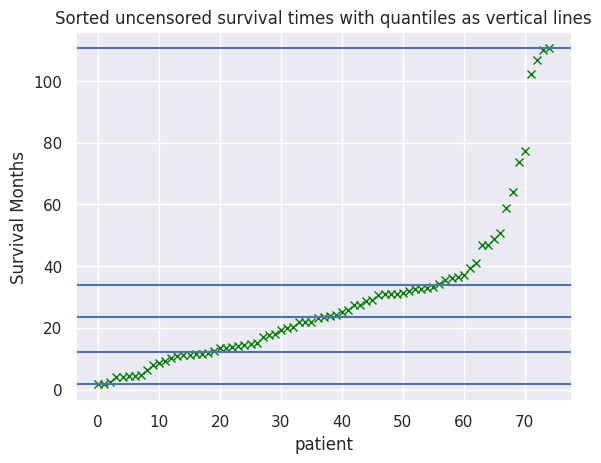

In [23]:

values = df_uncensored["survival_months"].values
values.sort()

plt.plot(values,"x",color = "green")
for line in bins:
    plt.axhline(line)
plt.xlabel("patient")
plt.ylabel("Survival Months")
plt.title("Sorted uncensored survival times with quantiles as vertical lines")
plt.show()

In [24]:
# adapt bins 
bins[0] = 0 
bins[-1] = np.inf

#
labels=[i for i in range(n_bins)]
labels


df.insert(6,"survival_months_discretized",  pd.cut(df["survival_months"],
                                                               bins=bins, 
                                                               labels=labels))
df.head(5)

,case_id,slide_id,site,is_female,oncotree_code,age,survival_months_discretized,survival_months,censorship,train,...,ZSWIM6,ZSWIM8,ZXDA,ZXDB,ZXDC,ZYG11A,ZYX,ZZEF1,ZZZ3,snoU13
0,TCGA-2E-A9G8,TCGA-2E-A9G8-01Z-00-DX1.DCD3E31B-1774-40BA-805...,2E,1,UCEC,59.0,3,41.03,1,1.0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-4E-A92E,TCGA-4E-A92E-01Z-00-DX1.60ED140E-11EA-49D7-ADF...,4E,1,UEC,54.0,0,0.43,1,1.0,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-4E-A92E,TCGA-4E-A92E-01Z-00-DX2.465234E4-02AC-40DF-975...,4E,1,UEC,54.0,0,0.43,1,1.0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-4E-A92E,TCGA-4E-A92E-01Z-00-DX3.F8F74B7E-0601-4084-AE3...,4E,1,UEC,54.0,0,0.43,1,1.0,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-5B-A90C,TCGA-5B-A90C-01Z-00-DX1.3F24BFBE-425C-456A-AFF...,5B,1,UEC,69.0,3,39.49,1,1.0,...,0,0,0,0,0,0,0,0,0,0


## Analyse different features 

In [25]:
patient_info_keys = df.keys()[:10] 
rnaseq_keys = [key for key in df.keys() if key.endswith("_rnaseq")]
cnv_keys = [key for key in df.keys() if key.endswith("_cnv")]
mut_keys = df.drop(rnaseq_keys,axis=1).drop(cnv_keys,axis=1).drop(patient_info_keys,axis=1).keys()

print(patient_info_keys)
print(rnaseq_keys)
print(cnv_keys)
print(mut_keys)

Index(['case_id', 'slide_id', 'site', 'is_female', 'oncotree_code', 'age',
       'survival_months_discretized', 'survival_months', 'censorship',
       'train'],
      dtype='object')
[]
['NOTCH2_cnv', 'ACP6_cnv', 'ANKRD20A12P_cnv', 'ANKRD34A_cnv', 'ANKRD35_cnv', 'BCL9_cnv', 'BOLA1_cnv', 'CD160_cnv', 'CHD1L_cnv', 'FAM72B_cnv', 'FAM72C_cnv', 'FAM72D_cnv', 'FCGR1A_cnv', 'FCGR1B_cnv', 'FMO5_cnv', 'GJA5_cnv', 'GJA8_cnv', 'GNRHR2_cnv', 'GPR89A_cnv', 'GPR89B_cnv', 'HIST2H2AA3_cnv', 'HIST2H2AA4_cnv', 'HIST2H2AB_cnv', 'HIST2H2AC_cnv', 'HIST2H2BA_cnv', 'HIST2H2BE_cnv', 'HIST2H2BF_cnv', 'HIST2H3A_cnv', 'HIST2H3C_cnv', 'HIST2H3D_cnv', 'HIST2H4A_cnv', 'HIST2H4B_cnv', 'HYDIN2_cnv', 'ITGA10_cnv', 'LINC00623_cnv', 'LINC00624_cnv', 'LIX1L_cnv', 'NBPF10_cnv', 'NBPF11_cnv', 'NBPF12_cnv', 'NBPF14_cnv', 'NBPF15_cnv', 'NBPF20_cnv', 'NBPF8_cnv', 'NBPF9_cnv', 'NUDT17_cnv', 'PDE4DIP_cnv', 'PDZK1P1_cnv', 'PDZK1_cnv', 'PEX11B_cnv', 'PIAS3_cnv', 'POLR3C_cnv', 'POLR3GL_cnv', 'PPIAL4A_cnv', 'PPIAL4C_cnv', 'PPIAL4

### RNA Seq

In [15]:
df_rnaseq = df[rnaseq_keys].copy()

n_patients, n_seqs = df_rnaseq.shape
values = df_rnaseq.values.flatten()
values.sort()

print(f"Size of rna_sequences patients: {n_patients} #rna_seq: {n_seqs}")
print(f"min value: {min(values)}")
print(f"max value: {max(values)}")

Size of rna_sequences patients: 538 #rna_seq: 0


ValueError: min() arg is an empty sequence

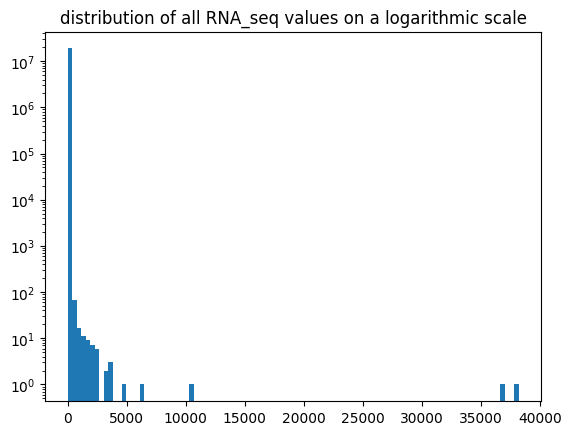

In [9]:
plt.hist(values,log=True,bins=100)
plt.title("Distribution of all RNA_seq values on a logarithmic scale")
plt.show()

### CNV

In [26]:
df_cnv = df[cnv_keys].copy()

n_patients, n_seqs = df_cnv.shape
values = df_cnv.values.flatten()
values.sort()

print(f"Size of #patients: {n_patients} #cnv_types: {n_seqs}")
print(f"min value: {min(values)}")
print(f"max value: {max(values)}")

Size of #patients: 539 #cnv_types: 935
min value: -2
max value: 2


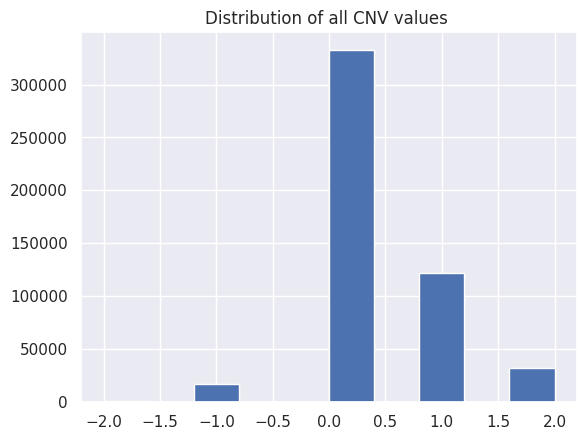

In [27]:
plt.hist(values)
plt.title("Distribution of all CNV values ")
plt.show()

### Mutations

In [28]:
df_mut = df[mut_keys].copy()

n_patients, n_seqs = df_mut.shape
values = df_mut.values.flatten()
values.sort()

print(f"Size of #patients: {n_patients} #mut_types: {n_seqs}")
print(f"min value: {min(values)}")
print(f"max value: {max(values)}")

Size of #patients: 539 #mut_types: 8137
min value: 0
max value: 1


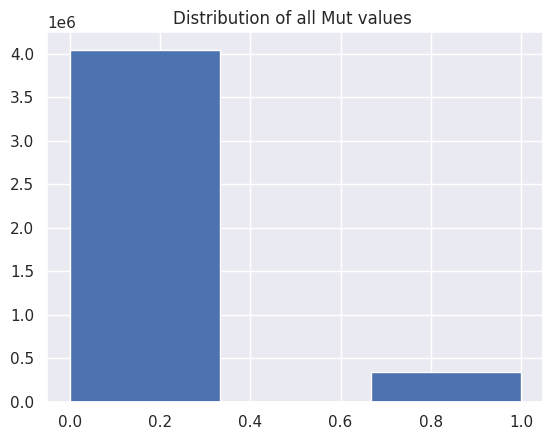

In [29]:
plt.hist(values,bins=3)
plt.title("Distribution of all Mut values ")
plt.show()

## Normalization 
The Porpoise pipeline applies a regular standard scaler to the genomic data which  transforms the features independently from each other to transform the data to a standard gauß distribution


from sklearn.preprocessing import StandardScaler

genomic_features = slide_data.drop(metadata, axis=1)
scaler_omic = StandardScaler().fit(genomic_features)